In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, Normalize, Compose
from torchvision.transforms import v2
import torch
from torch import nn
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn import metrics
import os
import time

KMEANS_ITERATIONS = 100
NR_CLUSTERS = 10
HOG_SIZE = 144
VOCABULARY_SIZE = 300
KEY_POINT_SIZE = 32
EDGETHRESHOLD = 20
VALIDATION = 0.2


matrix_transforms = v2.Compose([
    ToTensor(),
    Normalize(0.5, 0.5),
    Resize((64, 64))
])

def plot_losses(train_losses: list[float], validation_losses: list[float]) -> None:
    """Plots training and validation losses over epochs."""
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label="Training Loss", marker="o")
    plt.plot(validation_losses, label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

FASHION_BATCH_SIZE = 200

def get_fashion_dataloader(size : int):
    train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=matrix_transforms)
    test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=matrix_transforms)
    train_dataloader = DataLoader(train_data, batch_size=size, shuffle=False)
    test_dataloader = DataLoader(test_data, batch_size=size, shuffle=False)
    return train_data, test_data, train_dataloader, test_dataloader

train_fashion_dataset, test_fashion_dataset, train_fashion_dataloader, test_fashion_dataloader = get_fashion_dataloader(FASHION_BATCH_SIZE)
FASHION_KEYS = np.unique(train_fashion_dataset.targets)

In [12]:
class InfoLoaderDataset(Dataset):
    def __init__(self, data, labels, num_classes, transforms = None):
        self.data = data
        self.labels = labels
        self.num_classes = num_classes
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if (self.transforms == None):
            return self.data[idx], self.labels[idx]
        data = self.data[idx].detach().numpy()
        return self.transforms(data), self.labels[idx]

def initialiseTrainingModelHelpers(model, parameters):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['lr_optimizer'], weight_decay=parameters['weight_decay_factor'])
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                    factor=parameters['gamma_lr'], patience=parameters['patience'], verbose=True)
    return criterion, optimizer, lr_scheduler

def train(model, dataloader, optimizer, criterion, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    model.to(device)
    train_loss = 0
    all_preds = []
    all_labels= []
    for idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.type(torch.float32)
        labels = labels.type(torch.LongTensor)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    return train_loss / batch_size, accuracy_score(all_preds, all_labels)

def test(model, dataloader, criterion, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        validation_loss = 0
        all_preds = []
        all_labels= []
        for inputs, labels in dataloader:
            inputs = inputs.type(torch.float32)
            labels = labels.type(torch.LongTensor)
            inputs, labels = inputs.to(device), labels.to(device)
            out = model(inputs)
            validation_loss += criterion(out, labels).item()
            all_preds.extend(torch.argmax(out, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        return validation_loss / batch_size, accuracy_score(all_preds, all_labels), all_preds, all_labels

def train_model(model, train_dataloader, validation_dataloader, criterion, optimizer, lr_scheduler, batch_size, epochs):
    train_info = {
        "train_loss": [],
        "validation_loss" : [],
        "train_accuracy": [],
        "validation_accuracy" : []
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    max_acc = 0
    for i in range(epochs):
        train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, batch_size)
        val_loss, val_acc, _, _ = test(model, validation_dataloader, criterion, batch_size)
        time.sleep(2)
        if (val_acc > max_acc):
            max_acc = val_acc
            print("acuratete maxima la epoca", i)
        lr_scheduler.step(val_loss)
        print(val_loss, val_acc, "epoch: ", i)
        train_info["train_loss"].append(train_loss)
        train_info["validation_loss"].append(val_loss)
        train_info["train_accuracy"].append(train_acc)
        train_info["validation_accuracy"].append(val_acc)
    return train_info

def test_model(model, dataloader, criterion, batch_size):
    loss, accuracy, pred, labels = test(model, dataloader, criterion, batch_size)
    print("loss was:", loss, " accuracy was:", accuracy)
    confusion_matrix = metrics.confusion_matrix(labels, pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    cm_display.plot()
    plt.show()


def execute_pipeline(model, data, parameters):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion, optimizer, lr_scheduler = initialiseTrainingModelHelpers(model, parameters)
    train_info = train_model(model, data["train"], data["validation"], criterion, optimizer,
                             lr_scheduler, parameters['batch_size'], parameters['epochs'])
    torch.save(model.state_dict(), "./mlp.pth")
    plot_losses(train_info["train_loss"], train_info["validation_loss"])
    plot_losses(train_info["train_accuracy"], train_info["validation_accuracy"])
    test_model(model, data["test"], criterion, parameters['batch_size'])


In [7]:
# Task 1
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

from task1_aux import compute_vocabulary, create_initial_features, compute_attributes
pd.set_option("display.precision", 15)
SIZE = (28, 28)
BATCH_SIZE = 100
# DE ADAUGAT TRANSFORMARI
vocabulary = compute_vocabulary(train_fashion_dataloader, 5)
print(vocabulary.shape)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
X_train, y_train = create_initial_features(train_fashion_dataloader, vocabulary, FASHION_BATCH_SIZE)
X_test, y_test = create_initial_features(test_fashion_dataloader, vocabulary, FASHION_BATCH_SIZE)
rf.fit(X_train, y_train)
accuracy_before = rf.score(X_test, y_test)
print(f'accuracy after one more step', accuracy_before)
importances = rf.feature_importances_
feature_names = range(vocabulary.shape[0])
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_features = feature_importance_df['Feature'][:64].values
vocabulary = vocabulary[top_features]
X_train, y_train, X_validation, y_validation, X_test, y_test = compute_attributes(vocabulary,
                            train_fashion_dataloader,  test_fashion_dataloader, FASHION_BATCH_SIZE, FASHION_KEYS, VALIDATION)
data = {
    "train":  DataLoader(InfoLoaderDataset(X_train, y_train, 10), BATCH_SIZE, shuffle=True),
    "validation": DataLoader(InfoLoaderDataset(X_validation, y_validation, 10), BATCH_SIZE, shuffle=True),
    "test": DataLoader(InfoLoaderDataset(X_test, y_test, 10), BATCH_SIZE, shuffle=True),
}
print(vocabulary.shape)

a ajuns la epoca: 0
a ajuns la epoca: 100
a ajuns la epoca: 200
(1500, 36)
accuracy after one more step 0.6591
(60000, 64) (60000,)
(10000, 64) (10000,)
(64, 36)


/home/alf/anul4/IA/tema2/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


acuratete maxima la epoca 0
2.227229651212692 0.6406666666666667 epoch:  0
acuratete maxima la epoca 1
2.189096677303314 0.6558333333333334 epoch:  1
acuratete maxima la epoca 2
2.1672868382930757 0.66875 epoch:  2
acuratete maxima la epoca 3
2.1606450474262235 0.67075 epoch:  3
acuratete maxima la epoca 4
2.158208200931549 0.6718333333333333 epoch:  4
acuratete maxima la epoca 5
2.15262646317482 0.6734166666666667 epoch:  5
acuratete maxima la epoca 6
2.1500806641578674 0.6748333333333333 epoch:  6
2.153375015258789 0.6730833333333334 epoch:  7
acuratete maxima la epoca 8
2.144851440191269 0.6799166666666666 epoch:  8
2.1483468651771545 0.67425 epoch:  9
2.146862794160843 0.6765 epoch:  10
2.147292232513428 0.6759166666666667 epoch:  11
acuratete maxima la epoca 12
2.144304699897766 0.68075 epoch:  12
2.151680045127869 0.6711666666666667 epoch:  13
2.149058974981308 0.675 epoch:  14
2.1471360337734224 0.6748333333333333 epoch:  15
2.15077831864357 0.6724166666666667 epoch:  16
2.14459

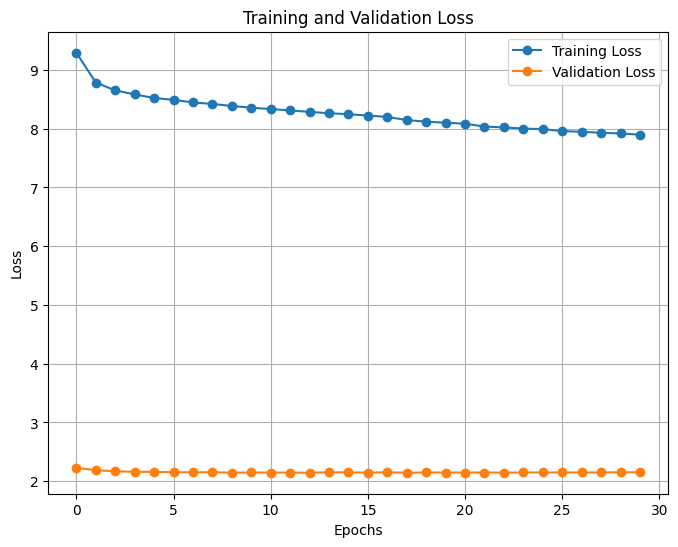

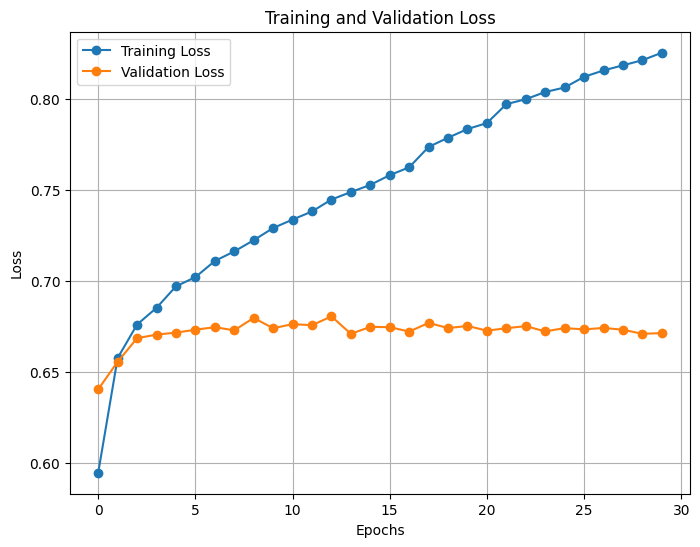

loss was: 1.7985795545578003  accuracy was: 0.6656


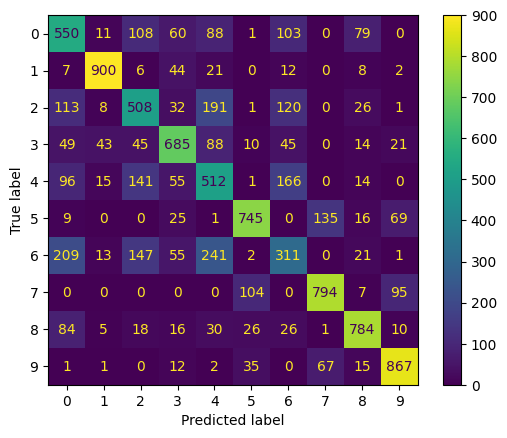

In [13]:
EXPANSION = 4
EPOCHS = 30
LR_OPTIMIZER = 1e-4
GAMMA_LR = 0.7
WEIGHT_DECAY_FACTOR = 1e-3
PATIENCE = 3


class FeaturesMLP(nn.Module):
    def __init__(self, initial_features, num_classes=10):
        super(FeaturesMLP, self).__init__()
        width1 = initial_features
        width2  = width1 * EXPANSION
        self.fc1 = nn.Linear(width1, width2)
        self.bn1 = nn.BatchNorm1d(width2)

        width3 = width2 * EXPANSION
        self.fc2 = nn.Linear(width2, width3)
        self.bn2 = nn.BatchNorm1d(width3)

        self.fc3 = nn.Linear(width3, width2)
        self.bn3 = nn.BatchNorm1d(width2)
        
        self.fc4 = nn.Linear(width2, width1)
        self.bn4 = nn.BatchNorm1d(width1)

        self.fc5 = nn.Linear(width1, num_classes)
        self.relu = nn.ReLU(inplace=True)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor):
        x = self.bn1(self.relu(self.fc1(x)))
        x = self.bn2(self.relu(self.fc2(x)))
        x = self.bn3(self.relu(self.fc3(x)))
        x = self.bn4(self.relu(self.fc4(x)))
        return self.softmax(self.fc5(x))

model = FeaturesMLP(64)
parameters = {
    'batch_size': BATCH_SIZE,
    'epochs' : EPOCHS,
    'lr_optimizer': LR_OPTIMIZER,
    'gamma_lr': GAMMA_LR,
    'weight_decay_factor': WEIGHT_DECAY_FACTOR,
    'patience': PATIENCE,
}

execute_pipeline(model, data, parameters)

In [15]:
# Task 2
from task1_aux import split_data_in_training_validation

class FullImageMLP(nn.Module):
    def __init__(self, num_classes=10):
        super(FullImageMLP, self).__init__()
        self.fc1 = nn.Linear(784, 250)
        self.bn1 = nn.BatchNorm1d(250)
        self.fc2 = nn.Linear(250, 250)
        self.bn2 = nn.BatchNorm1d(250)
        self.fc3 = nn.Linear(250, num_classes)
        self.relu = nn.ReLU(inplace=True)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor):
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.bn2(x)
        return self.softmax(self.fc3(x))

transforms = v2.Compose([
    ToTensor(),
    Resize(SIZE),
    Normalize(0.5, 0.5),
])

X_train, y_train, X_validation, y_validation = split_data_in_training_validation(train_fashion_dataset.data,
                                                    train_fashion_dataset.targets, FASHION_KEYS, VALIDATION)
X_test, y_test = test_fashion_dataset.data, test_fashion_dataset.targets
data = {
    "train" : DataLoader(InfoLoaderDataset(X_train, y_train, 10, transforms), BATCH_SIZE, shuffle=True),
    "validation": DataLoader(InfoLoaderDataset(X_validation, y_validation, 10, transforms), BATCH_SIZE, shuffle=True),
    "test": DataLoader(InfoLoaderDataset(X_test, y_test, 10, transforms), BATCH_SIZE, shuffle=True)
}

/home/alf/anul4/IA/tema2/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


acuratete maxima la epoca 0
1.965281935930252 0.842 epoch:  0
acuratete maxima la epoca 1
1.9408304810523986 0.8589166666666667 epoch:  1
acuratete maxima la epoca 2
1.9267529106140138 0.8683333333333333 epoch:  2
acuratete maxima la epoca 3
1.9208986282348632 0.8708333333333333 epoch:  3
acuratete maxima la epoca 4
1.9173533964157103 0.87275 epoch:  4
1.9168696439266204 0.87225 epoch:  5
acuratete maxima la epoca 6
1.912111120223999 0.8743333333333333 epoch:  6
acuratete maxima la epoca 7
1.9068811190128327 0.8791666666666667 epoch:  7
acuratete maxima la epoca 8
1.902262487411499 0.8844166666666666 epoch:  8
1.904831473827362 0.8816666666666667 epoch:  9
1.9045158338546753 0.881 epoch:  10
1.906660374403 0.8803333333333333 epoch:  11
1.9050755310058594 0.88225 epoch:  12
acuratete maxima la epoca 13
1.8962040448188782 0.8885 epoch:  13
1.8960684025287629 0.8875833333333333 epoch:  14
1.8964989376068115 0.8884166666666666 epoch:  15
1.8961041533946992 0.8878333333333334 epoch:  16
acu

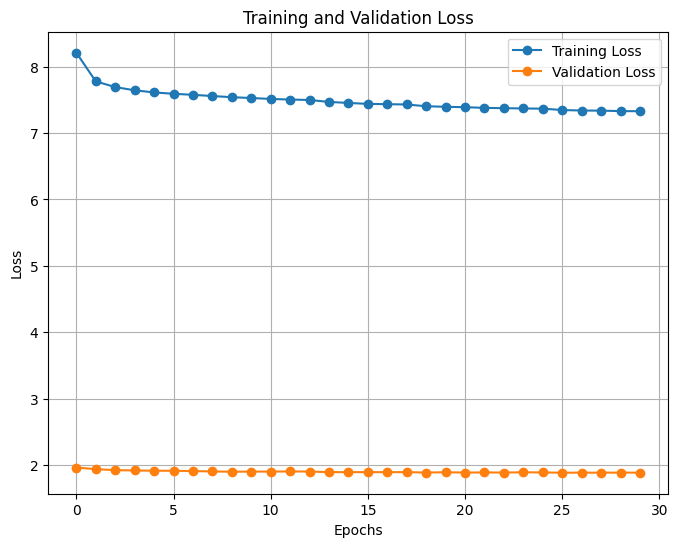

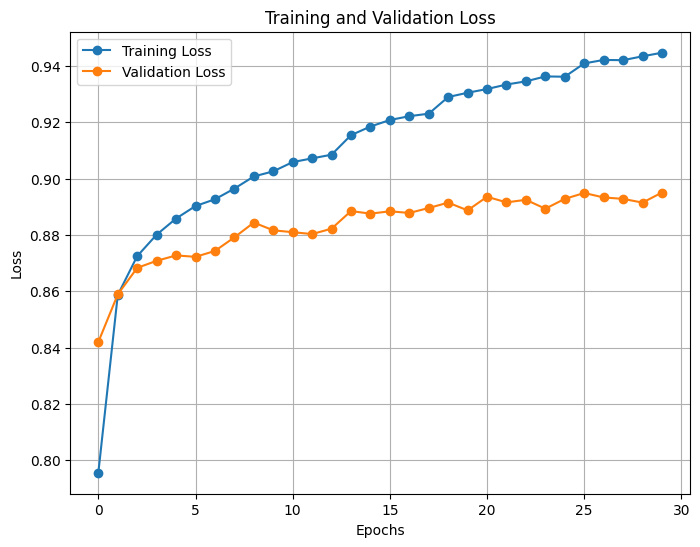

loss was: 1.5804855275154113  accuracy was: 0.8872


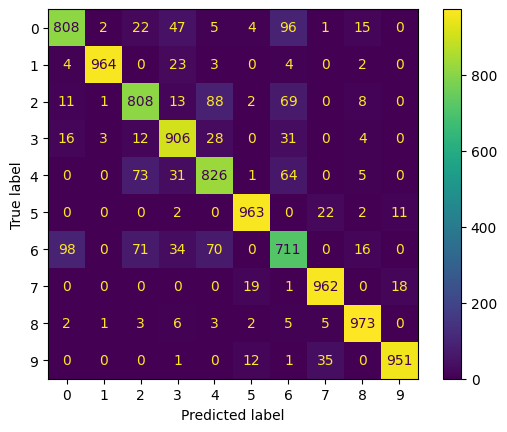

In [16]:

model = FullImageMLP()
parameters = {
    'batch_size': BATCH_SIZE,
    'epochs' : EPOCHS,
    'lr_optimizer': LR_OPTIMIZER,
    'gamma_lr': GAMMA_LR,
    'weight_decay_factor': WEIGHT_DECAY_FACTOR,
    'patience': PATIENCE,
}

execute_pipeline(model, data, parameters)

In [ ]:
# Task 3
from task1_aux import split_data_in_training_validation
SIZE = (28, 28)
BATCH_SIZE = 100
EPOCHS = 20
LR_OPTIMIZER = 1e-3
GAMMA_LR = 0.9
WEIGHT_DECAY_FACTOR = 1e-3
PATIENCE = 3
VALIDATION = 0.2
BASE_DEPTH = 16
EXPANSION = 4
NR_LAYERS_BLOCK = 2

class Task3ImageLoader(Dataset):
    def __init__(self, data, labels, num_classes, transforms = None):
        self.data = data
        self.labels = labels
        self.num_classes = num_classes
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if (self.transforms == None):
            return self.data[idx], self.labels[idx]
        return self.transforms(self.data[idx].detach().numpy()), self.labels[idx]


training_transforms = v2.Compose([
    ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(degrees=90),
    v2.RandomCrop(
      size=(SIZE),
      padding=(4, 4),
      padding_mode="reflect"),
    Resize(SIZE),
    Normalize(0.5, 0.5)
])

testing_transforms = v2.Compose([
    ToTensor(),
    Resize(SIZE),
    Normalize(0.5, 0.5)
])

X_train, y_train, X_validation, y_validation = split_data_in_training_validation(train_fashion_dataset.data,
                                                    train_fashion_dataset.targets, FASHION_KEYS, VALIDATION)
X_test, y_test = test_fashion_dataset.data, test_fashion_dataset.targets
data = {
    "train": DataLoader(InfoLoaderDataset(X_train, y_train, 10, training_transforms), BATCH_SIZE, shuffle=True),
    "validation": DataLoader(InfoLoaderDataset(X_validation, y_validation, 10, testing_transforms), BATCH_SIZE, shuffle=True),
    "test":  DataLoader(InfoLoaderDataset(X_test, y_test, 10, testing_transforms), BATCH_SIZE, shuffle=True),
}

In [ ]:
def conv3x3(in_planes, out_planes, stride=1, padding=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=padding, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class ConvBlock(nn.Module):
    def __init__(self, bottleneck_channels, block_channels, norm_layer):
        super(ConvBlock, self).__init__()
        self.conv1 = conv1x1(block_channels, bottleneck_channels)
        self.norm1 = norm_layer(bottleneck_channels)
        self.conv2 = conv3x3(bottleneck_channels, bottleneck_channels)
        self.norm2 = norm_layer(bottleneck_channels)
        self.conv3 = conv1x1(bottleneck_channels, block_channels)
        self.norm3 = norm_layer(block_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.norm3(out)
        out += identity
        out = self.relu(out)
        return out

class DeepConvNet(nn.Module):
    def __init__(self, base_depth=BASE_DEPTH, expansion=EXPANSION, nr_layer_blocks=NR_LAYERS_BLOCK, num_classes=10):
        super(DeepConvNet, self).__init__()
        self.base_depth = base_depth
        # convert image to grayscale before applying transformation
        self.conv1 = nn.Conv2d(1, self.base_depth, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.relu = nn.ReLU(inplace=True)
        depth1 = self.base_depth * expansion
        self.conv_depth1 = conv1x1(self.base_depth, depth1, stride=1)
        self.norm_depth1 = nn.BatchNorm2d(depth1)
        # # #### Layer 1, 3 blocks
        self.layer1 = nn.Sequential(
            *[ConvBlock(self.base_depth, depth1, nn.BatchNorm2d)] * nr_layer_blocks
        )

        # # change to 128 channels base and image size 8x8
        depth2 = depth1 * expansion
        self.conv_depth2 = conv1x1(depth1, depth2, 2)
        self.norm_depth2 = nn.BatchNorm2d(depth2)

        # #### Layer 2, 3 blocks
        self.layer2 = nn.Sequential(
            *[ConvBlock(depth1, depth2, nn.BatchNorm2d)] * nr_layer_blocks
        )

        # change to 256 chanels and image size 4x4
        depth3 = depth2 * expansion
        self.conv_depth3 = conv1x1(depth2, depth3, 2)
        self.norm_depth3 = nn.BatchNorm2d(depth3)

        # Layer 3, 3 blocks
        self.layer3 = nn.Sequential(
            *[ConvBlock(depth2, depth3, nn.BatchNorm2d)] * nr_layer_blocks
        )

        depth4 = depth3 * expansion
        self.conv_depth4 = conv1x1(depth3, depth4, 2)
        self.norm_depth4 = nn.BatchNorm2d(depth4)
        self.layer4 = nn.Sequential(
            *[ConvBlock(depth3, depth4, nn.BatchNorm2d)] * nr_layer_blocks
        )

        # # AveragePooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classification_layer = Compose([
            nn.Linear(depth4, depth3),
            nn.Dropout(0.3),
            nn.Linear(depth3, depth2),
            nn.Dropout(0.3),
            nn.Linear(depth2, num_classes)
        ])


    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.conv_depth1(x)
        x = self.norm_depth1(x)
        x = self.layer1(x)

        x = self.relu(self.conv_depth2(x))
        x = self.norm_depth2(x)
        x = self.layer2(x)

        x = self.conv_depth3(x)
        x = self.norm_depth3(x)
        x = self.layer3(x)

        x = self.conv_depth4(x)
        x = self.norm_depth4(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # de la clasification layer
        return self.classification_layer(x)

In [ ]:
model = DeepConvNet()
parameters = {
    'batch_size': BATCH_SIZE,
    'epochs' : EPOCHS,
    'lr_optimizer': LR_OPTIMIZER,
    'gamma_lr': GAMMA_LR,
    'weight_decay_factor': WEIGHT_DECAY_FACTOR,
    'patience': PATIENCE,
    'validation': VALIDATION,
    'base_depth': BASE_DEPTH,
    'expansion': EXPANSION, 
    'nr_layers_block': NR_LAYERS_BLOCK,
}
execute_pipeline(model, parameters)
